**Instructor**: Prof. Keith Chugg (chugg@usc.edu)

**Teaching Assistant**: Alexios Rustom (arustom@usc.edu)

**Book**: Watt, J., Borhani, R., & Katsaggelos, A. K. (2020). Machine learning refined: Foundations, algorithms, and applications. Cambridge University Press.

**Notebooks**: Written by Alexios Rustom (arustom@usc.edu) and based on the following **Github repository**: [notebooks](https://github.com/jermwatt/machine_learning_refined/tree/gh-pages/presentations/2nd_edition/jupyter%20%2B%20reveal.js%20version)

# Support Vector Machines

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import copy
from IPython.display import clear_output
readDataPath = './readData/'

In [2]:
## This code cell will not be shown in the HTML version of this notebook
# using an automatic differentiator - like the one imported via the statement below - makes coding up gradient descent a breeze
from autograd import numpy as np
from autograd import value_and_grad 

# gradient descent function - inputs: g (input function), alpha (steplength parameter), max_its (maximum number of iterations), w (initialization)
def gradient_descent(g,alpha_choice,max_its,w, data, labels, inputs_flag = False ):
    # compute the gradient function of our input function - note this is a function too
    # that - when evaluated - returns both the gradient and function evaluations (remember
    # as discussed in Chapter 3 we always ge the function evaluation 'for free' when we use
    # an Automatic Differntiator to evaluate the gradient)
    gradient = value_and_grad(g)

    # run the gradient descent loop
    weight_history = []      # container for weight history
    cost_history = []        # container for corresponding cost function history
    alpha = 0
    for k in range(1,max_its+1):
        # check if diminishing steplength rule used
        if alpha_choice == 'diminishing':
            alpha = 1/float(k+1)
        else:
            alpha = alpha_choice
        
        # evaluate the gradient, store current weights and cost function value
        if (inputs_flag == True):
            cost_eval,grad_eval = gradient(w,data,labels)
        else:
            cost_eval,grad_eval = gradient(w)
            
        weight_history.append(w)
        cost_history.append(cost_eval)

        # take gradient descent step
        w = w - alpha*grad_eval
            
    # collect final weights
    weight_history.append(w)
    # compute final cost function value via g itself (since we aren't computing 
    # the gradient at the final step we don't get the final cost function value 
    # via the Automatic Differentiatoor) 
    if (inputs_flag == True):
        cost_history.append(g(w,data,labels))
    else:
        cost_history.append(g(w))  
    return weight_history,cost_history

In [3]:
import autograd.numpy as np
from autograd import value_and_grad 
from autograd import hessian
from autograd.misc.flatten import flatten_func
from autograd import grad as compute_grad
from autograd import hessian as compute_hess

def newtons_method(g,max_its,w,epsilon, x, labels):        
    # create gradient and hessian functions
    #self.g = g
    
    # flatten gradient for simpler-written descent loop
    flat_g, unflatten, w = flatten_func(g, w)
    
    grad = compute_grad(flat_g)
    hess = compute_hess(flat_g)
    
    # create container for weight history 
    w_hist = []
    cost_history = []
    w_hist.append(unflatten(w))
        
    geval_old = flat_g(w,x,labels)
    
    for k in range(max_its):
        # compute gradient and hessian
        grad_val = grad(w,x,labels)
        hess_val = hess(w,x,labels)
        hess_val.shape = (np.size(w),np.size(w))

        # solve linear system for weights
        w = w - np.dot(np.linalg.pinv(hess_val + epsilon*np.eye(np.size(w))),grad_val)
                
        # eject from process if reaching singular system
        geval_new = flat_g(w,x,labels)
        if k > 2 and geval_new > geval_old:
            print ('singular system reached')
            time.sleep(1.5)
            clear_output()
            return w_hist
        else:
            geval_old = geval_new
            
        # record current weights
        w_hist.append(unflatten(w))
    
    return w_hist

In [4]:
def margin_perceptron(w,x,y): #Equation 6.50
    cost = 0
    for p in range(0,len(y)):
        x_p = x[p]
        y_p = y[p]
        a_p = w[0] + sum([a*b for a,b in zip(w[1:],x_p)])
        cost += np.maximum(0,1-y_p*a_p)
    return cost

In [5]:
def softmargin(w,x,y): #SOFTMAX approximation
    lam = 10**(-3)
    cost = 0
    for p in range(0,len(y)):
        x_p = x[p]
        y_p = y[p]
        a_p = w[0] + sum([a*b for a,b in zip(w[1:],x_p)])                
        cost += np.log(1 + np.exp(-y_p*a_p))+ lam*np.dot(w[1:].T,w[1:])
    return cost

- In this Section we begin by discussing an often used variation of the perceptron called the *margin perceptron*.  


- This perspective extends the notion of the perceptron described previously under the assumption that a dataset is linearly separable.  


- The margin perceptron will lead us to discuss *Support Vector Machines*, a popular perspective on linear classification again under the assumption of linear seperability. 

- This approach provides interesting theoretical insight into the two-class classification process - particularly under the assumption that the data is linearly seperable.  

- However we will see that in practice the Support Vector Machines approach does not provide a learned decision boundary that substantially differs from those provided by logistic regression or, likewise, the perceptron. 

## The margin-perceptron

- Suppose once again that we have a two-class classification training dataset of $P$ points $\left\{ \left(\mathbf{x}_{p},y_{p}\right)\right\} _{p=1}^{P}$ with the labels $y_p \in \{-1,+1\}$.  


- Suppose for the time being that we are dealing with a two-class dataset that is linearly separable with a known linear decision boundary

\begin{equation}
\mathring{\mathbf{x}}^{T}\mathbf{w}^{\,} = 0.
\end{equation}


- Suppose even further that this decision boundary passes evenly through the region separating our two classes.  

- This separating hyperplane creates a buffer between the two classes confined between two evenly shifted versions of itself.


- One version that lies on the positive side of the separator and just touches the class having labels $y_{p}=+1$ taking the form $\mathring{\mathbf{x}}^{T}\mathbf{w}^{\,}  =+1$, and one lying on the negative side of it just touching the class with labels $y_{p}=-1$ taking the form $\mathring{\mathbf{x}}^{T}\mathbf{w}^{\,} =-1$.  

- The translations above and below the separating hyperplane are more generally defined as $\mathring{\mathbf{x}}^{T}\mathbf{w}^{\,} =+\beta^{\,}$ and $\mathring{\mathbf{x}}^{T}\mathbf{w}^{\,} =-\beta^{\,}$ respectively, where $\beta>0$. 

- However by dividing off $\beta$ in both equations and reassigning the variables as $\mathbf{w}^{\,}\longleftarrow\frac{\mathbf{w}^{\,}}{\beta}$ we can leave out the redundant parameter $\beta$ and have the two translations as stated $\mathring{\mathbf{x}}^{T}\mathbf{w}^{\,}=\pm1$. 


- The fact that all points in the $+1$ class lie exactly on or on the positive side of $\mathring{\mathbf{x}}^{T}\mathbf{w}^{\,}=+1$, and all points in the $-1$ class lie exactly on or on the negative side of $\mathring{\mathbf{x}}^{T}\mathbf{w}^{\,}=-1$ can be written formally as the following conditions


\begin{equation}
\begin{array}{cc}
\mathring{\mathbf{x}}^{T}\mathbf{w}^{\,}\geq1 & \,\,\,\,\text{if} \,\,\, y_{p}=+1\\
\,\,\,\, \mathring{\mathbf{x}}^{T}\mathbf{w}^{\,}\leq-1 & \,\,\,\,\text{if} \,\,\, y_{p}=-1
\end{array}
\end{equation}

- We can combine these conditions into a single statement by multiplying each by their respective label values, giving the single inequality $y_{p}^{\,}\,\mathring{\mathbf{x}}^{T}\mathbf{w}^{\,}\geq1$ which can be equivalently written as a point-wise cost

\begin{equation}
g_p\left(\mathbf{w}\right) = \text{max}\left(0,\,1-y_{p}^{\,}\,\mathring{\mathbf{x}}^{T}\mathbf{w}^{\,}\right)=0
\end{equation}


- Again, this value is always nonnegative. Summing up all $P$ equations of the form above gives the *Margin-Perceptron* cost

\begin{equation}
g\left(\mathbf{w}\right)=\underset{p=1}{\overset{P}{\sum}}\text{max}\left(0,\,1-y_{p}^{\,}\,\mathring{\mathbf{x}}^{T}\mathbf{w}^{\,}\right)
\end{equation}

- Notice the striking similarity between the original perceptron cost from the previous post and the margin perceptron cost above: naively we have just 'added a $1$' to the non-zero input of the max function in each summand. 


- However this additional $1$ prevents the issue of a trivial zero solution with the original perceptron discussed previously, which simply does not arise here. 

- If the data is indeed linearly separable any hyperplane passing between the two classes will have parameters $\mathbf{w}$ where $g\left(\mathbf{w}\right)=0$. 


- However the margin perceptron is still a valid cost function even if the data is not linearly separable. 


- The only difference is that with such a dataset we can not make the criteria above hold for all points in the dataset. 


- Thus a violation for the $p^{\textrm{th}}$ point adds the positive value of $1-y_{p}^{\,}\,\mathring{\mathbf{x}}^{T}\mathbf{w}^{\,}$ to the cost function.

## The softmax and Margin-Perceptron cost

- If we have modeled something well but the associated cost function is difficult to minimize it can be more expedient to re-fashion the cost, even if we lose considerable modeling precision, if the new cost function is considerably easier to optimize.  


- Here 'easier to optimize' could mean a number of things - perhaps a steplength parameter is less sensitive (meaning a larger range of potential values will provide good results), or a broader set of optimization tools can be brought to bear. 


- The opposite holds as well - a cost function that is easy to minimize but models no useful phenomenon is a mere curiosity.

- As with the perceptron, one way to smooth out the margin-perceptron here is by replacing the $\text{max}$ operator with $\text{softmax}$. Doing so in one summand of the margin-perceptron gives the related summand


\begin{equation}
\text{soft}\left(0,1-y_{p}^{\,}\,\mathring{\mathbf{x}}^{T}\mathbf{w}^{\,}\right) = \text{log}\left( 1 + e^{1-y_{p}^{\,}\,\mathring{\mathbf{x}}^{T}\mathbf{w}^{\,}}\right)
\end{equation}


- Right away if we were to sum over all $P$ we could form a softmax-based cost function that closely matches the margin-perceptron. 

- But note how in the derivation of the margin perceptron the '1' used in the $1-y_{p}^{\,}\left(\mathring{\mathbf{x}}^{T}\mathbf{w}^{\,}\right)$ component of the cost could have been any number we wanted - it was a normalization factor for the width of the margin and, by convention, we used '1'.  


- Instead we could have chosen any value $\epsilon > 0$ in which case the set of $P$ conditions stated in equation (2) would be equivalently stated as

\begin{equation}
\text{max}\left(0,\,\epsilon-y_{p}^{\,}\,\mathring{\mathbf{x}}^{T}\mathbf{w}^{\,}\right)=0
\end{equation}

- So for all $p$ and the Margin-Perceptron equivalently stated as 

\begin{equation}
g\left(\mathbf{w}\right)=\underset{p=1}{\overset{P}{\sum}}\text{max}\left(0,\,\epsilon-y_{p}^{\,}\,\mathring{\mathbf{x}}^{T}\mathbf{w}^{\,}\right)
\end{equation}


- And the softmax version of one summand here being

\begin{equation}
\text{soft}\left(0,\epsilon-y_{p}^{\,}\,\mathring{\mathbf{x}}^{T}\mathbf{w}^{\,}\right) = \text{log}\left( 1 + e^{\epsilon-y_{p}^{\,}\,\mathring{\mathbf{x}}^{T}\mathbf{w}^{\,}}\right)
\end{equation}

- When $\epsilon$ is quite small we of course have that $\text{log}\left( 1 + e^{\epsilon-y_{p}^{\,}\,\mathring{\mathbf{x}}^{T}\mathbf{w}^{\,}}\right) \approx \text{log}\left( 1 + e^{-y_{p}^{\,}\,\mathring{\mathbf{x}}^{T}\mathbf{w}^{\,}}\right)$.


- That is, the same summand used for the (smoothed) perceptron and logistic regression.  


- Thus, we can in fact use the same softmax cost function here as a smoothed version of our Margin-Perceptron cost


\begin{equation}
g\left(\mathbf{w}\right)=\underset{p=1}{\overset{P}{\sum}}\text{log}\left( 1 + e^{-y_{p}^{\,}\,\mathring{\mathbf{x}}^{T}\mathbf{w}^{\,}}\right)
\end{equation}

- From the perspective of the standard perceptron this realization is somewhat redundant.


- A decision boundary recovered via the perceptron on a linearly separable dataset will almost always have a non-zero margin. 


- So this just says its smoothed version will do the same.

##  A quest for the hyperplane with maximum margin

- When two classes of data are linearly separable infinitely many hyperplanes could be drawn to separate the data. 


- Given that both classifiers (as well as any other decision boundary perfectly separating the data) would perfectly classify the data, is there one that we can say is the 'best' of all possible separating hyperplanes?  

- One reasonable standard for judging the quality of these hyperplanes is via their margin lengths, that is the distance between the evenly spaced translates that just touch each class. 


- The larger this distance is the intuitively better the associated hyperplane separates the entire space given the particular distribution of the data. 

- In our venture to recover the maximum margin seperating hyperplane, it will be convenient to use our individual notation for the bias and feature-touching weights:

\begin{equation}
\text{(bias):}\,\, b = w_0 \,\,\,\,\,\,\,\, \text{(feature-touching weights):} \,\,\,\,\,\, \boldsymbol{\omega} = 
\begin{bmatrix}
w_1 \\
w_2 \\ 
\vdots \\
w_N
\end{bmatrix}.
\end{equation}

- With this notation we can express a linear decision boundary as


\begin{equation}
\mathring{\mathbf{x}}_{\,}^T \mathbf{w} = b + \overset{\,}{\mathbf{x}}_{\,}^T\boldsymbol{\omega} = 0.
\end{equation}

- To find the separating hyperplane with maximum margin we aim to find a set of parameters so that the region defined by $b+\mathbf{x}^{T}\boldsymbol{\omega}^{\,}=\pm1$, with heach translate just touching one of the two classes, has the largest possible margin.  


- The margin can be determined by calculating the distance between any two points (one from each translated hyperplane) both lying on the normal vector $\boldsymbol{\omega}$. 

- Denoting by $\mathbf{x}_{1}$ and $\mathbf{x}_{2}$ the points on vector $\boldsymbol{\omega}$ belonging to the *positive* and *negative* translated hyperplanes, respectively, the margin is computed simply as the length of the line segment connecting $\mathbf{x}_{1}$ and $\mathbf{x}_{2}$, i.e., $\left\Vert \mathbf{x}_{1}-\mathbf{x}_{2}\right\Vert _{2}$. 


- The margin can be written much more conveniently by taking the difference of the two translates evaluated at $\mathbf{x}_{1}$ and $\mathbf{x}_{2}$ respectively, as 

\begin{equation}
\left(w_0^{\,} + \mathbf{x}_{1}^T\mathbf{w}^{\,}\right) - \left(w_0^{\,} + \mathbf{x}_{2}^T\mathbf{w}^{\,}\right) =\left(\mathbf{x}_{1}^{\,}-\mathbf{x}_{2}^{\,}\right)^{T}\boldsymbol{\omega}=2
\end{equation}

- Using the inner product rule, and the fact that the two vectors $\mathbf{x}_{1}-\mathbf{x}_{2}$ and $\boldsymbol{\omega}$ are parallel to each other, we can solve for the margin directly in terms of $\boldsymbol{\omega}$, as 

\begin{equation}
\left\Vert \mathbf{x}_{1}-\mathbf{x}_{2} \right\Vert _2=\frac{2}{\left\Vert \boldsymbol{\omega}\right\Vert _{2}}
\end{equation}


- Therefore finding the separating hyperplane with maximum margin is equivalent to finding the one with the smallest possible normal vector $\boldsymbol{\omega}$. 

## The hard-margin and soft-margin SVM problems

- In order to find a separating hyperplane for the data with minimum length normal vector we can simply combine...


- ...our desire to minimize $\left\Vert \boldsymbol{\omega}\right\Vert _{2}^{2}$...


- ...subject to the constraint that the hyperplane perfectly separates the data (given by the margin criterion described above). 


- This gives the so-called *hard-margin support vector machine* problem


\begin{equation}
\begin{aligned}\underset{b,\,\boldsymbol{\omega}}{\text{minimize}} & \,\,\left\Vert \boldsymbol{\omega}\right\Vert _{2}^{2}\\
\text{subject to} & \,\,\,\text{max}\left(0,\,1-y_{p}^{\,}\left(b+\mathbf{x}_{p}^{T}\boldsymbol{\omega}\right) \right)=0,\,\,\,\,p=1,...,P.
\end{aligned}
\end{equation}

- The set of constraints here are precisely the margin-perceptron guarantee that the hyperplane we recover separates the data perfectly.


- Unlike some of the other constrained optimization problems we have previously discussed this cannot be solved in closed form, but must be optimized iteratively.

- While there are *constrained optimization* algorithms that are designed to solve problems like this as stated.


- We can also solve the hard-margin problem by *relaxing* the constraints and forming an unconstrained formulation of the problem.  


- To do this we merely bring the constraints up, forming a single cost function to be minimized


\begin{equation}
g\left(b,\boldsymbol{\omega}\right)=\underset{p=1}{\overset{P}{\sum}}\text{max}\left(0,\,1-y_{p}^{\,}\left(b+\mathbf{x}_{p}^{T}\boldsymbol{\omega}\right) \right) +  \lambda \left \Vert\boldsymbol{\omega}\right\Vert _{2}^{2}
\end{equation}

- Here the parameter $\lambda\geq0$ is called a penalty or regularization parameter (we have seen the notion of regularization in the previous Section as well).  


- When $\lambda$ is set to a small positive value we put more 'pressure' on the cost function to make sure the constraints

\begin{equation}
\text{max}\left(0,\,1-y_{p}^{\,}\left(b+\mathbf{x}_{p}^{T}\boldsymbol{\omega}\right) \right)=0,\,\,\,\,p=1,...,P
\end{equation}

- In theory when $\lambda$ is made very small the formulation above matches the original constrained form.  

- Because of this $\lambda$ is often set to be quite small in practice.


- This *regularized* form of the Margin-Perceptron cost function is referred to as the *soft-margin support vector machine cost*.  

#### <span style="color:#a50e3e;">Example. </span>  Comparing the SVM decision boundary on linearly separable data

- In this example we compare the support vector machine decision boundary learned to three boundaries learned via the margin-perceptron.  


- All of the recovered boundaries perfectly separate the two classes, but the support vector machine decision boundary is the one that provides the maximum margin (right panel)...


- ...while those recovered by the margin-perceptron (left panel, each colored differently) can ostensibly be any of the infinitely many linear decision boundaries that separate the two classes. 

In [6]:
data_loaded = np.loadtxt(readDataPath + 'svm_demo_data.csv',delimiter = ',')
data = copy.deepcopy(data_loaded).T

In [7]:
x = data[:-1]
y_labels = data[-1]

### Margin-Perceptron

In [8]:
lam = 0; max_its = 50; alpha_choice = 'diminishing'; g = margin_perceptron;

In [9]:
num_margin_perceptron_runs = 3

In [10]:
big_whist = []
for i in range(num_margin_perceptron_runs):
    w_init = np.random.randn(np.shape(x)[1]+1,1)
    #w_hist, cost_history = gradient_descent(g,alpha_choice,max_its,w_init, data = x.T+1, labels = y_labels, inputs_flag=True)
    w_hist, cost_history = gradient_descent(g,alpha_choice,max_its,w_init, data = x.T, labels = y_labels, inputs_flag=True)
    w = w_hist[-1]
    big_whist.append(w)

### Soft Margin-SVM

In [11]:
lam = 10**(-3); max_its = 10; epsilon = 10**-8; g = softmargin

In [12]:
w_init = np.random.randn(np.shape(x)[0]+1,1)
#w_hist = newtons_method(g,max_its,w_init, epsilon, x.T+1, y_labels)
w_hist = newtons_method(g,max_its,w_init, epsilon, x.T, y_labels)
w = w_hist[-1]
big_whist.append(w)

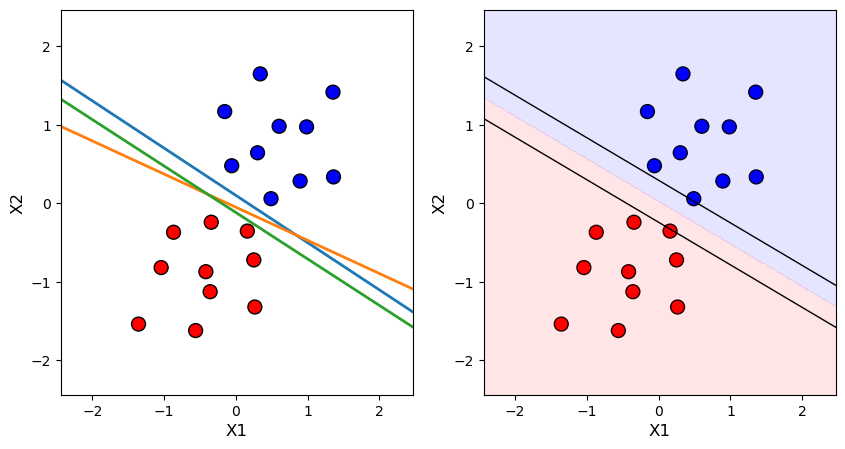

In [13]:
fig, [ax1,ax2] = plt.subplots(1, 2, figsize=(10, 5))

col = np.where(data[-1]==1,'r','b')
#ax1.scatter(data[0]+1,data[1]+1,c= col, s=100,facecolors='k', edgecolors='k')
#ax2.scatter(data[0]+1,data[1]+1,c= col, s=100,facecolors='k', edgecolors='k')
ax1.scatter(data[0],data[1],c= col, s=100,facecolors='k', edgecolors='k')
ax2.scatter(data[0],data[1],c= col, s=100,facecolors='k', edgecolors='k')
ax1.set_xlabel('X1', fontsize = 12)
ax2.set_xlabel('X1', fontsize = 12)
ax1.set_ylabel('X2', fontsize = 12)
ax2.set_ylabel('X2', fontsize = 12)

#minx = min(min(x[0]),min(x[1]))+1
#maxx = max(max(x[0]),max(x[1]))+1
minx = min(min(x[0]),min(x[1]))
maxx = max(max(x[0]),max(x[1]))
gapx = (maxx - minx)*0.25
minx -= gapx
maxx += gapx
s = np.linspace(minx,maxx,400)
for i in range(num_margin_perceptron_runs):
    w = big_whist[i]
    # plot 
    t = - ((w[0])/float(w[2]) + w[1]/float(w[2])*s ) 
    ax1.plot(s,t,linewidth = 2,zorder = 1)


w = big_whist[-1]
r = np.linspace(minx,maxx,400)
x1_vals,x2_vals = np.meshgrid(r,r)
x1_vals.shape = (len(r)**2,1)
x2_vals.shape = (len(r)**2,1)

g_vals = np.tanh( w[0] + w[1]*x1_vals + w[2]*x2_vals ) #values between -1 and 1
g_vals = np.asarray(g_vals, dtype=np.double)
x1_vals.shape = (len(r),len(r))
x2_vals.shape = (len(r),len(r))
g_vals.shape = (len(r),len(r))
g_vals = np.sign(g_vals) + 1
ax2.contourf(x1_vals,x2_vals,g_vals,alpha = 0.1,levels = range(0,2+1), colors = ['blue', 'red'])


w_c = copy.deepcopy(w)
w_0 = -w_c[0]/w_c[2]  # amount to subtract from the vertical of each point

# setup line to project onto
w_1 = -w_c[1]/w_c[2]

#ax2.plot(1,w_1,'x')
#ax2.plot(0,0,'o')
line_pt = np.asarray([1,w_1], dtype=np.double)
line_pt.shape = (2,1)
line_hat = line_pt / np.linalg.norm(line_pt)
line_hat.shape = (2,1)

# loop over points, compute distance of projections                     
dists = []
for j in range(len(y_labels)):
    #pt = copy.deepcopy(x[:,j]+1)
    pt = copy.deepcopy(x[:,j])
    pt[1]-= w_0
    pt.shape = (2,1)
    proj = np.dot(line_hat.T,pt)*line_hat  
    proj.shape = (2,1)
    d = np.linalg.norm(proj - pt)
    #ax2.plot((proj - pt)[0],(proj - pt)[1],'d')
    dists.append(d)                  

#ax2.plot(x[:,j][0]+1,x[:,j][1]+1,'o')
#ax2.plot(proj[0],proj[1],'s')
# find smallest distance to class point
ind = np.argmin(dists)
#pt_min = copy.deepcopy(x[:,ind]+1)
pt_min = copy.deepcopy(x[:,ind])

#ax2.plot(x[:,ind][0]+1,x[:,ind][1]+1,'s')
# create new intercept with y intercept (thus it will be with respect to line that passes through the origin)
w_new = -w_1*pt_min[0] + pt_min[1]

margin = copy.deepcopy(w_new)

# plot margin planes
s = np.linspace(minx,maxx,400)
t = - ((w[0])/float(w[2]) + w[1]/float(w[2])*s ) + margin
ax2.plot(s,t,color = 'k',linewidth = 1,zorder = 1)

t = - ((w[0])/float(w[2]) + w[1]/float(w[2])*s ) - margin
ax2.plot(s,t,color = 'k',linewidth = 1,zorder = 1)

ax1.set_xlim(minx,maxx); ax1.set_ylim(minx,maxx)
ax2.set_xlim(minx,maxx); ax2.set_ylim(minx,maxx)
    
plt.show()

## The SVM and noisy datasets

- A very big practical benefit of the softmargin SVM problem is that it allows us it to deal with noisy imperfectly (linearly) separable data - which arise far more commonly in practice than datasets that are perfectly linearly separable.   


- 'Noise' is permittable with the softmargin problem since regardless of the weights $b$ and $\boldsymbol{\omega}$, we always have some data point which is misclassified, i.e., for some $p$ that $\text{max}\left(0,\,1-y_{p}^{\,}\left(b+\mathbf{x}_{p}^{T}\boldsymbol{\omega}\right) \right)>0$.  


- Such a case makes the first hard-margin formulation of SVMs infeasible, as no such $w_0$ and $\boldsymbol{\omega}$ even exist that satisfy the constraints.   

- Because we commonly deal with non-separable datasets in practice the softmargin form of SVM is the version that is more frequently used.


- However notice that once we forgo the assumption of perfectly (linear) separability the added value of a 'maximum margin hyperplane' proided by the SVM solution disappears since we *no longer have a margin to begin with*.  

- Thus with many datasets in practice the softmargin problem does *not* provide a solution remarkably different than the perceptron or even logistic regression.  


- Actually - with datasets that are not linearly separable - it often returns *exactly* the same solution provided by the perceptron or logistic regression.

- To see why this could be the case notice what happens to our softmargin SVM problem if we *smooth* the Margin-Perceptron portion of the cost using the *softmax* (as detailed previously).  


- This gives a smoothed out soft-margin SVM cost function of the form

\begin{equation}
g\left(b,\boldsymbol{\omega}\right)=\underset{p=1}{\overset{P}{\sum}}\text{log}\left( 1 + e^{-y_{p}\left(b+\mathbf{x}_{p}^{T}\boldsymbol{\omega}\right)}\right) +  \lambda \left \Vert\boldsymbol{\omega}\right\Vert _{2}^{2} 
\end{equation}


- which we can also identify as a regularized softmax perceptron or logistic regression. 

- Thus we can see that all three methods of linear two-class classification we have seen are very deeply connected, and why they tend to provide similar results on realistic (not linearly separabble) datasets.

# Which approach produces the best results?

- We have now seen three approaches, logistic regression, the perceptron, and Support Vector Machines, each of brings a valuable and unique perspective to bear on two class classification.  


- Which of these approaches 'works best' in practice?  As we have seen, in the end all three approaches are very tightly related and result in the minimization of the same (e.g., the Softmax cost) - or very similar - cost functions.  


- Therefore it should come as little surprise that while they can differ from dataset to dataset in terms of their performance, in practice all three approaches typically give compariable results.  


- Thus one should feel comfortable using any one of the three approaches or, if resources allow, apply multiple of them and keep whichever produces the best performance on a case by case basis.